# Project Description

You will implement a model which inputs a sentence (such as "Ходімо грати у бейсбол!") and finds the most appropriate emoji to be used with this sentence (⚾️). In many emoji interfaces, you need to remember that ❤️ is the "heart" symbol rather than the "love" symbol. But using word vectors, you'll see that even if your training set explicitly relates only a few words to a particular emoji, your algorithm will be able to generalize and associate words in the test set to the same emoji even if those words don't even appear in the training set. This allows you to build an accurate classifier mapping from sentences to emojis, even using a small training set.

In this exercise, you'll start with a baseline model (Emojifier-V1) using word embeddings, then build a more sophisticated model (Emojifier-V2) that further incorporates an LSTM.

In [1]:
import numpy as np
from emo_utils import *
import itertools
import emoji
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 
from string import punctuation


%matplotlib inline

# Prepare the dataset (emoji_set.csv)
1. Install emoji package: **pip install emoji**
2. Get familiar with its description: https://pypi.org/project/emoji/
3. Select 5 emoticons from the list: https://www.webpagefx.com/tools/emoji-cheat-sheet/
4. Make file **data/emoji_set.csv**
5. Give index for each emoticon:<br>
emoji, code, label<br>
❤️, :heart:, 0<br>
😄, :smile:, 1<br>
...<br>
6. For each emoticon prepare 30 sentences **in Ukrainian**
7. Your dataset should look like:<br>
X (sentences), Y(labels)<br>
Я тебе кохаю, 0<br>
Він пишається твоїми досягненнями, 1<br>
...
8. Read-in your dataset, shuffle and divide into **train** and **test**

In [2]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('data/emoji_set.csv')
# delete extra emoji data
data = data.set_index('emo')
data = data.drop([2,3,6,8], axis=0)
data.reset_index(level=0, inplace=True)
# replace lables with proper ones
data = data.replace({7:3, 5:2})

# shuffle
# divide into train and test
train_set, test_set = train_test_split(data, test_size=0.2)
train_set.reset_index(level=0, inplace=True)
test_set.reset_index(level=0, inplace=True)

X_train, Y_train = train_set['sentence'], train_set['emo']
X_test, Y_test = test_set['sentence'], test_set['emo']

# get max len
maxLen = len(max(X_train, key=len).split())

# X_train.head(10)
maxLen

14

Check out sentences from X_train and corresponding labels from Y_train. Change index to see different examples.

In [3]:
index = 67
print(X_train[index], label_to_emoji(Y_train[index]))

з Брі ідеально поєднується червоне напівсолодке 🍷


# Baseline model: Emojifier-V1
The input of the model is a string corresponding to a sentence (e.g. "Я тебе кохаю"). In the code, the output will be a probability vector of shape (1,5), that you then pass in an argmax layer to extract the index of the most likely emoji output.<br><br>
To get our labels into a format suitable for training a softmax classifier, lets convert $Y$ from its current shape $(m, 1)$ into a "one-hot representation" $(m, 5)$, where each row is a one-hot vector giving the label of one example, You can do so using this next code snipper. Here, Y_oh stands for "Y-one-hot" in the variable names Y_oh_train and Y_oh_test:

In [4]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

Let's see what convert_to_one_hot() did. Feel free to change index to print out different values.

In [5]:
index = 56
print(Y_train[index], "is converted into one hot", Y_oh_train[index])

4 is converted into one hot [0. 0. 0. 0. 1.]


All the data is now ready to be fed into the Emojify-V1 model. Let's implement the model!

## Load pretrained embeddings
Load the embeddings into existing **data** folder.<br>
Where: http://lang.org.ua/uk/models/<br>
Alternative: https://fasttext.cc/docs/en/crawl-vectors.html

## Implement Emojifier-V1
1. Read-in loaded embeddings
2. Convert an input sentence into the word vector representation
3. Average

In [6]:
# correct glove embeddings file name
# for other types of embeddings, write similar function (see emo_utils.py)

# FOR TEACHER: could not load embeddings to cms, so it should be added manually
# http://lang.org.ua/uk/models/ - embeddings were taken from here, filename: ubercorpus.lowercased.tokenized.glove.300d
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/embeddings/ubercorpus.lowercased.tokenized.glove.300d')

You've loaded:

- _word_to_index_: dictionary mapping from words to their indices in the vocabulary (400,001 words, with the valid indices ranging from 0 to 400,000)
- _index_to_word_: dictionary mapping from indices to their corresponding words in the vocabulary
- _word_to_vec_map_: dictionary mapping words to their GloVe vector representation.
<br><br>
Check how it works

In [7]:
word = "сорочка"
index = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

the index of сорочка in the vocabulary is 449701
the 289846th word in the vocabulary is манежну


In [8]:
word_to_vec_map[word]

array([-0.202566, -0.152461,  0.273252,  0.43998 ,  0.340374, -0.027129,
       -0.511444,  0.052295,  0.312061,  0.484661, -0.100827,  0.752109,
        0.277506, -0.099236, -0.06783 ,  0.211145,  0.088827,  0.293651,
       -0.047532,  0.195477,  0.263267,  0.247959,  0.991235, -0.0131  ,
        0.403789,  0.062206, -0.628421,  0.366798, -0.212452,  0.02419 ,
        0.398341,  0.41902 ,  0.116066, -0.223738,  0.436459,  0.132193,
        0.047671, -0.039363, -0.1924  ,  0.019029,  0.415354,  0.440581,
       -0.415394,  0.331891,  0.324355, -0.334673,  0.258301,  0.388409,
       -0.326078, -0.105734,  0.251011, -0.450468, -0.054073,  0.046614,
        0.148379,  0.322822, -0.270945, -0.021871,  0.005213, -0.491005,
        0.832585, -0.561881,  0.372609, -0.01073 ,  0.028112, -0.402091,
       -0.234341, -0.341824, -0.518201, -0.132458, -0.30245 , -0.239102,
        0.103483, -0.0223  , -0.012894,  0.147111,  0.544218,  0.335769,
        0.250099, -0.078551,  0.133362,  0.286324, 

Implement sentence_to_avg(). You will need to carry out two steps:

1. Convert every sentence to lower-case, then split the sentence into a list of words. X.lower() and X.split() might be useful.
2. For each word in the sentence, access its GloVe representation. Then, average all these values.

In [9]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    
    # Split sentence into list of lower case words (≈ 1 line)
    
    words = sentence.split()

    # Initialize the average word vector, should have the same shape as your word vectors.  
    # Average the word vectors. You can loop over the words in the list "words".
    avg = np.average(np.array([word_to_vec_map[w.lower().strip(punctuation)] for w in words if w.lower().strip(punctuation) in word_to_vec_map.keys()]), axis=0)
    
    return avg

In [10]:
len(word_to_vec_map.keys())

538432

In [11]:
avg = sentence_to_avg("Моя улюблена страва - борщ", word_to_vec_map)
print("avg = ", avg)
# you should see list of emdeddings, len = 300 

avg =  [ 8.2720750e-02 -4.0378875e-01  1.1845625e-01  3.7466175e-01
  4.1694750e-01  9.2225750e-02 -1.4972425e-01 -7.8347750e-02
 -1.7910175e-01  2.8469000e-02  1.1168850e-01 -7.2144750e-02
  4.1083450e-01  5.7449750e-02  1.1564850e-01  2.7584025e-01
  2.0631175e-01  1.7669825e-01  2.1849475e-01 -3.6545100e-01
 -8.6625750e-02 -1.8236000e-01  8.9491000e-02 -1.0846625e-01
 -3.9958000e-02 -5.2662500e-02 -1.3894950e-01 -5.5855800e-01
  2.6169150e-01 -5.0539250e-02  1.1708900e-01  3.1745575e-01
  6.2013000e-02 -5.6345000e-01  5.8713900e-01 -1.0732525e-01
 -1.9575750e-02 -2.4756900e-01 -3.9907125e-01 -2.1557250e-02
  2.2161825e-01  9.4812000e-02  2.7228050e-01  3.9333475e-01
  2.3758425e-01  4.8851100e-01  2.7107550e-01 -3.3270850e-01
 -9.2400250e-02  8.0005500e-02  2.1286525e-01 -1.8693450e-01
 -4.5224050e-01  1.0046575e-01 -3.4040750e-02 -1.2737875e-01
 -1.2887025e-01  1.6719350e-01 -3.4892750e-02  3.0689525e-01
 -3.5443375e-01 -1.0574275e-01  2.3164800e-01  3.7576000e-02
 -1.9160975e-01  

**Model**
<br><br>
You now have all the pieces to finish implementing the model() function. After using sentence_to_avg() you need to pass the average through forward propagation, compute the cost, and then backpropagate to update the softmax's parameters.



Implement the model() function described in Figure (2). Assuming here that $Yoh$ ("Y one hot") is the one-hot encoding of the output labels, the equations you need to implement in the forward pass and to compute the cross-entropy cost are: $$ z^{(i)} = W . avg^{(i)} + b$$$$ a^{(i)} = softmax(z^{(i)})$$$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Yoh^{(i)}_k * log(a^{(i)}_k)$$
<br><br>
It is possible to come up with a more efficient vectorized implementation. But since we are using a for-loop to convert the sentences one at a time into the avg^{(i)} representation anyway, let's not bother this time.
<br><br>
softmax() function is implemented in emo_utils.py

In [12]:
def predict(X, Y, W, b, word_to_vec_map):
    pred = []
    for i in range(Y.shape[0]):
        avg = sentence_to_avg(X[i], word_to_vec_map)
        z = np.dot(W, avg) + b
        pred.append(np.argmax(softmax(z)))
    return np.array(pred)   

In [13]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    np.random.seed(1)

    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 300                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations):                       # Loop over the number of iterations
        for i in range(m):                                # Loop over the training examples
            
            ### START CODE HERE ### (≈ 4 lines of code)
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(Y_oh[i] * np.log(a))
            ### END CODE HERE ###
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

Train your model and learn the softmax parameters (W,b).

In [14]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.935691655216577
Epoch: 100 --- cost = 0.2664482567692332
Epoch: 200 --- cost = 0.1203452532383932
Epoch: 300 --- cost = 0.07624980345420106
[3 2 2 4 2 3 0 1 2 4 1 1 0 2 4 2 2 0 2 1 0 0 1 0 0 4 4 0 3 0 4 3 3 3 2 4 2
 0 1 1 0 4 0 1 3 1 2 4 4 2 3 0 4 3 0 2 4 1 2 4 2 1 2 4 2 0 2 2 1 4 2 1 0 0
 1 2 4 2 2 0 2 0 0 1 1 0 3 2 4 1 2 1 4 0 4 4 0 3 1 2 4 4 3 3 2 1 1 3 1 1 4
 1 0 2 0]


In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_train, pred)

1.0

Expected accuracy - 97% or more, expected cost - 0.03 or less

## Test set performance

In [16]:
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)  # ~97% or more
print("Training set: ", accuracy_score(Y_train, pred_train))
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)  # ~85% or more
print('Test set: ', accuracy_score(Y_test, pred_test))

Training set:  1.0
Test set:  0.5172413793103449


In the training set, the algorithm saw the sentence "Я тебе кохаю" with the label ❤️. You can check however that the word "обожнюю" does not appear in the training set. Nonetheless, lets see what happens if you write "Я обожнюю тебе"
<br>
If your dataset doesn't contain such a sentence, create example for your case on your own.

In [17]:
# set messages appropriate to your dataset!
X_my_sentences = np.array(["такий спокійний вечір", "твоє виноградне шампанське терпке", "сердита, бо знову пропустила маршрутку", "я не змогла з нею поговорити", "тони цієї кімнати підходять для спальні", "ти виродок"])
Y_my_labels = np.array([[3], [2], [1], [0], [3], [1]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
# print_predictions(X_my_sentences, pred)
pd.DataFrame({'my_centences': X_my_sentences, 'predicted_labels': pred, 'real_labels': [3,2,1,0,3,1]})

,my_centences,predicted_labels,real_labels
0,такий спокійний вечір,0,3
1,твоє виноградне шампанське терпке,2,2
2,"сердита, бо знову пропустила маршрутку",4,1
3,я не змогла з нею поговорити,0,0
4,тони цієї кімнати підходять для спальні,2,3
5,ти виродок,1,1


"обожнюю" has a similar embedding as "кохаю", the algorithm should generalize correctly even to a word it has never seen before.
<br><br>
Note though that it doesn't get "не почуваюся щасливим" correct. This algorithm ignores word ordering, so is not good at understanding phrases like "не щасливий"
<br><br>
Printing the confusion matrix can also help understand which classes are more difficult for your model. A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(29,)
           😭    😠    🍷    😴   💩
Predicted  0   1  2  3  4  All
Actual                        
0          1   4  0  1  1    7
1          1   4  0  0  0    5
2          0   0  7  0  0    7
3          0   0  1  0  1    2
4          2   3  0  0  3    8
All        4  11  8  1  5   29
Confusion matrix, without normalization
[[1 4 0 1 1]
 [1 4 0 0 0]
 [0 0 7 0 0]
 [0 0 1 0 1]
 [2 3 0 0 3]]


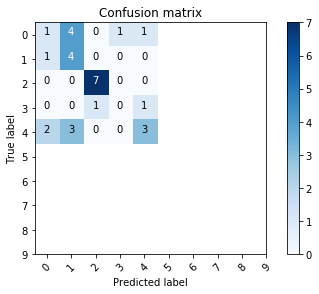

In [19]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True))

np.set_printoptions(precision=2)
class_names = range(10)
cnf_matrix = confusion_matrix(Y_test, pred_test)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names)

**Conclusions:**
- Even with a 150 training examples, you can get a reasonably good model for Emojifying. This is due to the generalization power word vectors gives you.
- Emojify-V1 will perform poorly on sentences such as "Цей фільм мені не подобається" because it doesn't understand combinations of words--it just averages all the words' embedding vectors together, without paying attention to the ordering of words. You will build a better algorithm in the next part.

# Emojifier-V2: Using LSTMs in Keras

Let's build an LSTM model that takes as input word sequences. This model will be able to take word ordering into account. Emojifier-V2 will continue to use pre-trained word embeddings to represent words, but will feed them into an LSTM, whose job it is to predict the most appropriate emoji.

In [20]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

Using TensorFlow backend.


## Overview of the model
Here is the Emojifier-v2 you will implement:
![](../../../Downloads/emojifier-v2.png)

## Keras and mini-batching
We want to train Keras using mini-batches. However, most deep learning frameworks require that all sequences in the same mini-batch have the same length. This is what allows vectorization to work: If you had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.

The common solution to this is to use padding. Specifically, set a maximum sequence length, and pad all sequences to the same length. For example, of the maximum sequence length is 20, we could pad every sentence with "0"s so that each input sentence is of length 20. Thus, a sentence "i love you" would be represented as $(e_{i}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$. In this example, any sentences longer than 20 words would have to be truncated. One simple way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set.

## The Embedding layer
In Keras, the embedding matrix is represented as a "layer", and maps positive integers (indices corresponding to words) into dense vectors of fixed size (the embedding vectors). It can be trained or initialized with a pretrained embedding. In this part, you will learn how to create an Embedding() layer in Keras, initialize it with the GloVe 50-dimensional vectors loaded earlier in the notebook. Because our training set is quite small, we will not update the word embeddings but will instead leave their values fixed. But in the code below, we'll show you how Keras allows you to either train or leave fixed this layer.

The Embedding() layer takes an integer matrix of size (batch size, max input length) as input. This corresponds to sentences converted into lists of indices (integers), as shown in the figure below.
![](../../../Downloads/embedding1.png)
The largest integer (i.e. word index) in the input should be no larger than the vocabulary size. The layer outputs an array of shape (batch size, max input length, dimension of word vectors).

The first step is to convert all your training sentences into lists of indices, and then zero-pad all these lists so that their length is the length of the longest sentence.

**Implement the function below** to convert X (array of sentences as strings) into an array of indices corresponding to words in the sentences. The output shape should be such that it can be given to Embedding().

In [21]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        sentence_words = [w.lower().strip(punctuation) for w in sentence_words if w.lower().strip(punctuation) in word_to_vec_map.keys()]
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]

            # Increment j to j + 1
            j+=1
            
            
    ### END CODE HERE ###
    
    return X_indices

Let's build the Embedding() layer in Keras, using pre-trained word vectors. After this layer is built, you will pass the output of sentences_to_indices() to it as an input, and the Embedding() layer will return the word embeddings for a sentence.

**Implement pretrained_embedding_layer()**. You will need to carry out the following steps:

1. Initialize the embedding matrix as a numpy array of zeroes with the correct shape.
2. Fill in the embedding matrix with all the word embeddings extracted from word_to_vec_map.
3. Define Keras embedding layer. Use Embedding(). Be sure to make this layer non-trainable, by setting trainable = False when calling Embedding(). If you were to set trainable = True, then it will allow the optimization algorithm to modify the values of the word embeddings.
4. Set the embedding weights to be equal to the embedding matrix

In [22]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = 300     # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for w,i in word_to_index.items():
        emb_matrix[i, :] = word_to_vec_map[w]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

Check it:

In [23]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = 0.080119


## Building the Emojifier-V2
Lets now build the Emojifier-V2 model. You will do so using the embedding layer you have built, and feed its output to an LSTM network.

Exercise: Implement Emojify_V2(), which builds a Keras graph of the architecture shown in Figure 3. The model takes as input an array of sentences of shape (m, max_len, ) defined by input_shape. It should output a softmax probability vector of shape (m, C = 5). You may need Input(shape = ..., dtype = '...'), LSTM(), Dropout(), Dense(), and Activation().

In [24]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

Run the following cell to create your model and check its summary. Because all sentences in the dataset are less than 10 words, we chose max_len = 10. You should see your architecture, it uses "20,223,927" parameters, of which 20,000,050 (the word embeddings) are non-trainable, and the remaining 223,877 are. Because our vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001*50 = 20,000,050 non-trainable parameters.

In [25]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 14, 300)           161529900 
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 128)           219648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
__________

As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using categorical_crossentropy loss, adam optimizer and ['accuracy'] metrics:

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

It's time to train your model. Your Emojifier-V2 model takes as input an array of shape (m, max_len) and outputs probability vectors of shape (m, number of classes). We thus have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [27]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

Fit the Keras model on X_train_indices and Y_train_oh. We will use epochs = 50 and batch_size = 32.

In [28]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
115/115 [==============================] - 19s 165ms/step - loss: 1.6029 - acc: 0.2174
Epoch 2/50
115/115 [==============================] - 1s 5ms/step - loss: 1.5395 - acc: 0.3652
Epoch 3/50
115/115 [==============================] - 1s 4ms/step - loss: 1.4447 - acc: 0.3739
Epoch 4/50
115/115 [==============================] - 1s 7ms/step - loss: 1.2829 - acc: 0.4783
Epoch 5/50
115/115 [==============================] - 1s 5ms/step - loss: 1.1197 - acc: 0.4870
Epoch 6/50
115/115 [==============================] - 1s 5ms/step - loss: 1.0602 - acc: 0.5826
Epoch 7/50
115/115 [==============================] - 1s 7ms/step - loss: 0.9396 - acc: 0.6348
Epoch 8/50
115/115 [==============================] - 1s 6ms/step - loss: 0.7798 - acc: 0.7304
Epoch 9/50
115/115 [==============================] - 1s 7ms/step - loss: 0.6177 - acc: 0.7826
Epoch 10/50
115/115 [==============================] - 1s 8ms/step - loss: 0.4404 - acc: 0.8261
Epoch 11/50
115/115 [=========================

Your model should perform close to **100% accuracy** on the training set. The exact accuracy you get may be a little different. Run the following cell to evaluate your model on the test set.

In [29]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

29/29 [==============================] - 1s 31ms/step

Test accuracy =  0.5517241358757019


You should get a test accuracy between 80% and 95%. Run the cell below to see the mislabelled examples.

In [30]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[np.array(Y_test).reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😭 prediction: Нова гра не запускається на комп'ютері😠
Expected emoji:💩 prediction: Я поснідав в столовій😭
Expected emoji:😭 prediction: Давайте ревіти всі разом.😠
Expected emoji:💩 prediction: Тут дуже брудно😠
Expected emoji:💩 prediction: Чому все так погано тут😠
Expected emoji:🍷 prediction: Винний перегляд: різниця між французькими та південноамериканськими мальбами💩
Expected emoji:😴 prediction: гарної ночі💩
Expected emoji:😭 prediction: Фільм був дуже сумний💩
Expected emoji:😴 prediction: взагалі не цікаво💩
Expected emoji:😭 prediction: Дуже сильно обідився😠
Expected emoji:🍷 prediction: Алкоголь - це не рішення😠
Expected emoji:💩 prediction: Вчора мене пограбували🍷
Expected emoji:💩 prediction: Ненавижу такі заклади😠


Now you can try it on your own example. Write your own sentence below.

In [31]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['НЛП - це круто!'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

НЛП - це круто! 😠


Previously, Emojify-V1 model did not correctly label "not feeling happy," but our implementation of Emojiy-V2 got it right. (Keras' outputs are slightly random each time, so you may not have obtained the same result.) The current model still isn't very robust at understanding negation (like "не задоволений") because the training set is small and so doesn't have a lot of examples of negation. But if the training set were larger, the LSTM model would be much better than the Emojify-V1 model at understanding such complex sentences.

# Conclusions
- If you have an NLP task where the training set is small, using word embeddings can help your algorithm significantly. Word embeddings allow your model to work on words in the test set that may not even have appeared in your training set.
- Training sequence models in Keras (and in most other deep learning frameworks) requires a few important details:
    - To use mini-batches, the sequences need to be padded so that all the examples in a mini-batch have the same length.
    - An Embedding() layer can be initialized with pretrained values. These values can be either fixed or trained further on your dataset. If however your labeled dataset is small, it's usually not worth trying to train a large pre-trained set of embeddings.
    - LSTM() has a flag called return_sequences to decide if you would like to return every hidden states or only the last one.
    - You can use Dropout() right after LSTM() to regularize your network.